# [NTDS'18] Team project
[ntds'18]: https://github.com/mdeff/ntds_2018

## Students

* Team: `<34>`
* Students: `<Valentin Morel, Xavier Sieber, Cédric Schumacher, Charles-Théophile Coen>`
* Dataset: `<Terrorist attack>`

In [34]:
%matplotlib inline

import numpy as np
import networkx as nx
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from pyunlocbox import functions, solvers
from scipy.optimize import minimize as opt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.datasets import make_blobs
from sklearn import metrics

In [35]:
## Loading of files

# Features: mean of 126; std of 149
features = np.load('features_matrix.npy')

# Labels
labels =  np.load('labels_vector.npy')

# Location
adjacency_location = np.load('adjacency_location.npy')
n_nodes = len(adjacency_location)
location = np.load('location_vector.npy')

# Weighted adjacency matrix of the distance from features
adjacency_weights = np.load('adjacency_weights_matrix.npy')

gt = np.load('gt.npy')
x = np.load('projection_matrix.npy')

In [36]:
## Definition of fonctions

def distance_weighted(i,j):
    return adjacency_weights[i,j]

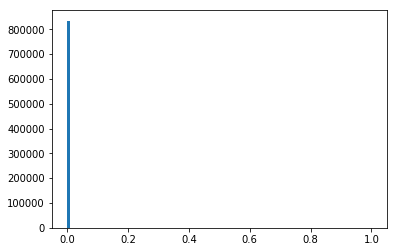

In [37]:
# Visualization of the distrubution of the distances of features
weights_hist = np.zeros(int(n_nodes*(n_nodes-1)/2))
n = 0
for i in range(0,n_nodes):
    for j in range(i+1,n_nodes):
        weights_hist[n] = adjacency_weights[i,j]
        n += 1
plt.hist(weights_hist, bins = np.linspace(0,1,100))   
plt.show()

##### **Remarks**
The adjacency_weights matrix allow us to picture the difference between two features. The smaller the value between two node's features the more similar they are in terms of their features.

In [38]:
unique_ele, unique_indices, unique_counts = np.unique(location, return_index = True, return_counts = True)
mapping = {}
for i in range(0,len(unique_ele)):
    if unique_counts[i] > 1:
        mapping[unique_ele[i]] = {'numbers':unique_counts[i], 'indices':np.where(location == unique_ele[i])[0]}
        

# List of keys of the dictionnary
keys = list(mapping.keys())
# List of values of dict containing numbers and indices of nodes with the same location
values = list(mapping.values()) 
# List of all the indexes of locations with more than one attack
index_attack = []
for i in range(0,len(keys)):
    index_attack.append(list(mapping[keys[i]]['indices']))
    
index_attack = [val for sublist in index_attack for val in sublist]   

In [39]:
weights_dict = {}
for i in keys:
    num_nodes_same_loc = mapping[i]['numbers']
    distances = np.zeros(int((num_nodes_same_loc)*(num_nodes_same_loc-1)/2))
    index = 0
    for j in range(0,num_nodes_same_loc):
        for k in range(j+1,num_nodes_same_loc):
            distances[index] = distance_weighted(mapping[i]['indices'][j],mapping[i]['indices'][k])
            index += 1

    weights_dict[i] = {'distances':distances, 'mean': np.mean(distances), 'std': np.std(distances)}

In [40]:
labels_dict = {}
for i in keys:
    num_nodes_same_loc = mapping[i]['numbers']
    lab = []
    for j in range(0,num_nodes_same_loc):
        lab.append(labels[mapping[i]['indices'][j]][0])

    labels_dict[i] = lab

recap_label = {}
for i in keys:
    unique_ele, unique_counts = np.unique(labels_dict[i], return_counts = True)
    total_attacks = mapping[i]['numbers']
    list_attacks = [];
    for j in range(0,len(unique_ele)):
        list_attacks.append({unique_ele[j]: np.round(unique_counts[j]/total_attacks*100)})

    list_attacks.append(total_attacks)
    recap_label[i] =  list_attacks

In [41]:
def plot_recap_label(k):
    
    numb = np.size(recap_label[k])-1
    x = []
    y = []
    for i in range(0,numb):
        x.append(list(recap_label[k][i].keys()))
        y.append(list(recap_label[k][i].values()))
        
    x = [val for sublist in x for val in sublist]
    y = [val for sublist in y for val in sublist] 
    
    plt.bar(x,y)
    plt.title('Distribution of attacks for location %i. Number of attacks at this location: %i.' %(k ,recap_label[k][-1]))
    plt.show()
    return

##### **Remarks**
The *mapping* dictionary contains the locations where multiple attacks were perpetrated. For each location, the number of attacks(n) is specified and the indices of the nodes are stored in an array.

The *weights_dict* dictionary contains the weighted distance in terms of features between every attacks perpetrated at the same location. The distances are stored in an array of *(n-1)n/2* values where n is the number of attacks at this location. The goal of this dictionary is to find any links between the colocated attacks and their features.

The *labels_dict* dictionary contains the type of attacks for the attacks perpetrated at the same location. *recap_label* dictionary is a summary of *labels_dict* with only the percentage for each type of attack. The goal of these dictionaries is to find any links between the colocated attacks and the type of attack.

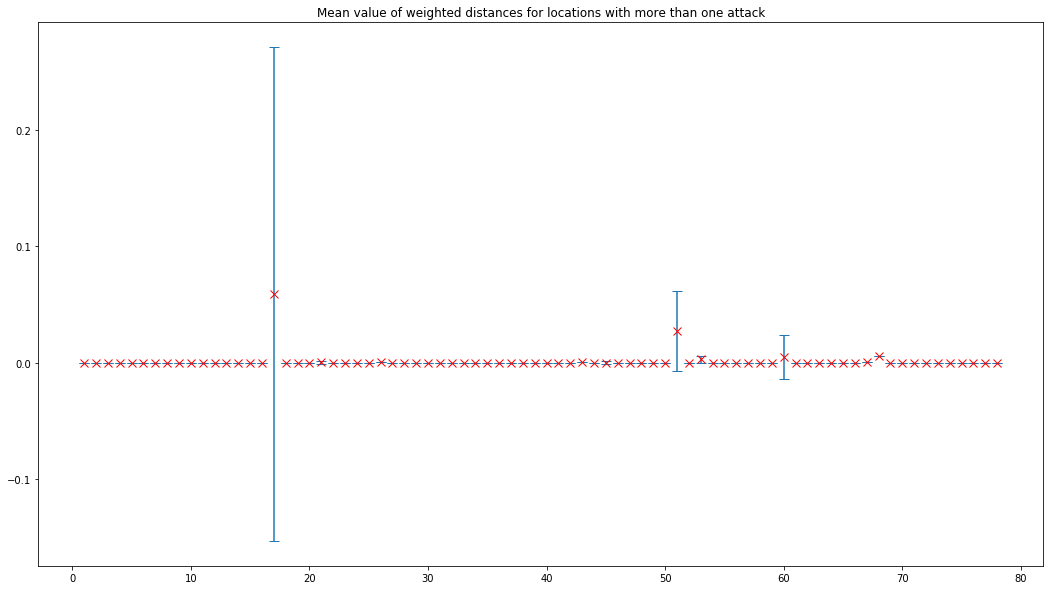

In [42]:
x = list(weights_dict.keys())
y = np.zeros(len(x))
yerr = np.zeros(len(x))
index = 0
for i in x:
    y[index] = weights_dict[i]['mean']
    yerr[index] = weights_dict[i]['std']
    index += 1

plt.figure(figsize=(18,10))
plt.errorbar(np.linspace(1,len(x),len(x)),y,yerr, linestyle='None',marker='x', markersize= 8,
                    markeredgecolor = [1,0,0],capsize=5)
plt.title('Mean value of weighted distances for locations with more than one attack')
plt.show()

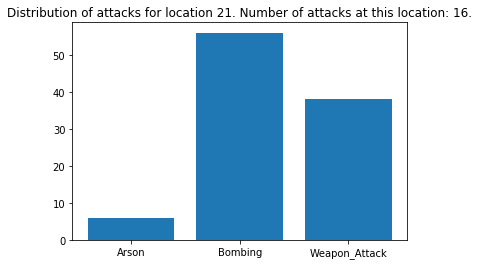

(None,
 {4.0: [{'Arson': 50.0}, {'Weapon_Attack': 50.0}, 2],
  11.0: [{'Arson': 20.0}, {'Bombing': 80.0}, 5],
  14.0: [{'Arson': 50.0}, {'Bombing': 50.0}, 2],
  15.0: [{'Arson': 33.0}, {'Bombing': 67.0}, 3],
  21.0: [{'Arson': 6.0}, {'Bombing': 56.0}, {'Weapon_Attack': 38.0}, 16],
  54.0: [{'Bombing': 94.0}, {'Weapon_Attack': 6.0}, 16],
  62.0: [{'Bombing': 100.0}, 5],
  63.0: [{'Bombing': 67.0}, {'Weapon_Attack': 33.0}, 3],
  83.0: [{'Bombing': 33.0}, {'Weapon_Attack': 67.0}, 3],
  86.0: [{'Bombing': 100.0}, 5],
  107.0: [{'Bombing': 100.0}, 5],
  116.0: [{'Bombing': 50.0}, {'Weapon_Attack': 50.0}, 2],
  127.0: [{'Bombing': 100.0}, 2],
  135.0: [{'Bombing': 33.0}, {'Weapon_Attack': 67.0}, 3],
  146.0: [{'Bombing': 50.0}, {'Weapon_Attack': 50.0}, 2],
  162.0: [{'Bombing': 67.0}, {'Weapon_Attack': 33.0}, 3],
  182.0: [{'Bombing': 100.0}, 7],
  207.0: [{'Bombing': 50.0}, {'Weapon_Attack': 50.0}, 4],
  208.0: [{'Bombing': 50.0}, {'Kidnapping': 50.0}, 2],
  215.0: [{'Bombing': 100.0}, 2],


In [10]:
plot_recap_label(21), recap_label

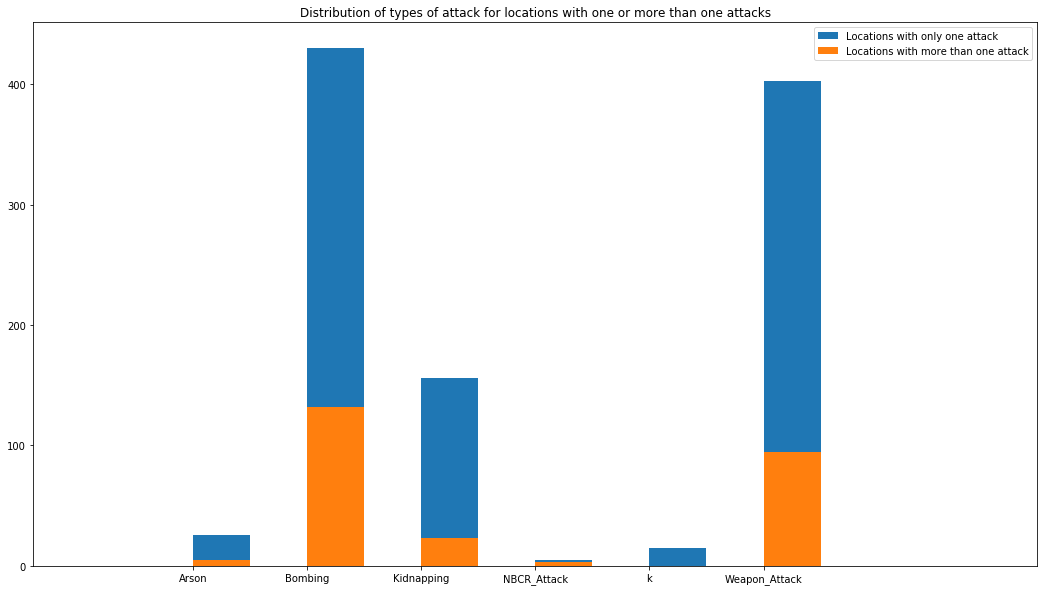

In [11]:
plt.figure(figsize=(18,10))
y_single_attack = np.take(labels,index_attack)
y_single_attack = np.reshape(y_single_attack,(y_single_attack.shape[0],1))

y_multiple_attack = np.delete(labels,index_attack)
y_multiple_attack = np.reshape(y_multiple_attack,(y_multiple_attack.shape[0],1))

plt.hist(y_multiple_attack, bins = np.linspace(-1,7,17))
plt.hist(y_single_attack, bins = np.linspace(-1,7,17))
plt.legend(('Locations with only one attack','Locations with more than one attack'))
plt.title('Distribution of types of attack for locations with one or more than one attacks')
plt.show()

##### **Remarks**

We see that the distribution of types of attack is almost the same between the locations with more than one attack (in orange) and the locations with only one attack (blue)

In [12]:
## Any ressemblance in terms of features for attacks with same label?
# Creation of a dictionnary with the 6 different types of attack and the indices of the nodes with this type of attack

unique_ele, unique_indices, unique_counts = np.unique(labels, return_index = True, return_counts = True)
dict_labels = {}
for i in range(0,len(unique_ele)):
    dict_labels[unique_ele[i]] = {'numbers':unique_counts[i], 'indices':np.where(labels == unique_ele[i])[0]}
        

In [13]:
e, U = np.linalg.eigh(adjacency_weights)

In [14]:
mydic = {'Arson':np.array([[1,0,0,0,0,0]]), 'Bombing':np.array([[0,1,0,0,0,0]]), 'Kidnapping':np.array([[0,0,1,0,0,0]]), 'NBCR_Attack':np.array([[0,0,0,1,0,0]]), 'Weapon_Attack':np.array([[0,0,0,0,1,0]]), 'k':np.array([[0,0,0,0,0,1]])}

mydic[labels[3][0]]
gt = mydic[labels[0][0]]
for i in range (1,len(labels)):
    gt = np.vstack((gt,mydic[labels[i][0]]))

x0 = np.zeros((106,6))

In [15]:
def costLS (x,f,gt):
    f_=f.astype(float)
    gt_=gt.astype(float)
    cost=0
    length=f_.shape[0]
    x=x.reshape((106,6))
    #print(f_.shape)
    #print(x.shape)
    #print(gt_.shape)
    
    if f_.shape[0] != gt_.shape[0]:
        exit('Dim missmatch')
    for i in range(0,length):
        #print(np.linalg.norm(np.dot(f_[i,:],x)-gt_[i,:]))
        tmp=np.linalg.norm(np.dot(f_[i,:],x)-gt_[i,:])
        cost += tmp
    
    #print(cost)
    return cost

In [16]:
def gradLS(x,f,gt):
    f_=f.astype(float)
    gt_=gt.astype(float)
    grad = np.zeros((106,6))
    
    for i in range (0,1293):
        er=np.dot(f_[i,:],x)-gt_[i,:]
        dif=f_[i,:]
        dif = dif.reshape((106,1))
        grad += 2*dif*er
    grad = grad/1293
    return grad

In [17]:
def grad_descent (x0,f,gt,niter,gam,verbose):
    
    tmp=x0
    for i in range (0,niter):
        x_p=tmp-gam*gradLS(tmp,f,gt)
        tmp=x_p
        if i%verbose==0:
            print(costLS(x_p,f,gt))
    return x_p


In [ ]:
#x=grad_descent(x0,features,gt,10000,0.1,100)

In [ ]:
tot=0
for i in range(0,1293):
    if np.argmax(gt[i,:])==np.argmax(np.dot(features[i,:],x)):
        tot +=1
perf=100/1293*tot
print(perf)

In [ ]:
print(np.dot(features[200,:],x))
gt[200,:]

In [ ]:
plt.hist(x[:,5], bins = np.linspace(0,1,100))   
plt.show()

In [ ]:
np.save('projection_matrix',x)
np.save('gt',gt)

In [20]:
def spectral_clustering (feature,kernel,thf,gt,weighted,Ltype,k,typ):
    
    #creating adjacency
    distances = pdist(feature, metric=kernel)
    kernel_width = distances.mean()
    weights = np.exp(-distances**2 / kernel_width**2)
    #plt.hist(tmp, bins = np.linspace(0,1,100))   
    #plt.show()
    if weighted==1:
        
        th=weights.mean()*thf
        #print(th)
        weights[weights<th]=0
        weights[weights>=th]=1
    adjacency = squareform(weights) # features identical: weigths = 0; features different: weights >= 1
    
    #laplacian
    degree=adjacency.sum(axis=0)
    adjacency = sparse.csr_matrix(adjacency)
    
    D = sparse.diags(degree)
    D_rw=sparse.diags(1/degree)
    D_n = sparse.diags(1/np.sqrt(degree))
    L = D - adjacency
    L_rw = D_rw.dot(L)
    L_n = D_n.dot(L.dot(D_n))
    
    if Ltype=='std':
        Lap=L
    if Ltype=='rw':
        Lap=L_rw
    if Ltype=='norm':
        Lap=L_n
    
    #spectral decomposition
    e, U = np.linalg.eigh(Lap.A)
    
    #plot eigenmaps
    #plt.figure(figsize=(18,12))
    #fig = plt.figure(figsize=(12,12))
    #ax = Axes3D(fig)
    #ax.scatter(U[:,1],U[:,2],U[:,3],c=np.argmax(gt,axis=1),cmap='rainbow')
    #plt.show()
    
    
    #clustering
    #sc 2
    if typ == 'sc':
        my_clust = SpectralClustering(k, affinity='precomputed')
    if typ == 'bi':
        my_clust = Birch(threshold= 0.8, n_clusters = k)
    if typ == 'hd':
        my_clust = hdbscan.HDBSCAN(min_cluster_size=k)
    if typ == 'km':
        my_clust = KMeans(k)
    
    
    #fig3 = plt.figure(figsize=(12,12))
    #ax3 = Axes3D(fig3)
    #ax3.scatter(U[:,1],U[:,2],U[:,3],c=my_clust.fit_predict(adjacency.A),cmap='rainbow')
    
    my_clust.fit_predict(adjacency.A)
    
    return my_clust

In [23]:
clus=spectral_clustering(features,'matching',1,gt,0,'norm',6,'bi')

#plt.draw()

In [24]:
mydic2 = {'Arson':1, 'Bombing':2, 'Kidnapping':3, 'NBCR_Attack':4, 'Weapon_Attack':5, 'k':6}
gt2 = (pd.DataFrame(labels).replace(mydic2)).values

In [25]:
metrics.adjusted_mutual_info_score(np.reshape(gt2,len(gt2)),clus.labels_)

/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.1799165677964007

In [31]:
typ_clust = ['bi','hd','km','sc']
typ_dist = ['euclidean','cosine']
nb_clust = [3,6]
for i in typ_clust:
    for j in typ_dist:
        for k in nb_clust:
            clus = spectral_clustering(features,j,1,gt,0,'norm',k,i)
            met = metrics.adjusted_mutual_info_score(np.reshape(gt2,len(gt2)),clus.labels_)
            print('For type clustering %s, with distance %s and number of cluster %i, metric of: %f' %(i,j,k,met))

/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering bi, with distance euclidean and number of cluster 3, metric of: 0.023759


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering bi, with distance euclidean and number of cluster 6, metric of: 0.085877


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering bi, with distance cosine and number of cluster 3, metric of: 0.271017


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering bi, with distance cosine and number of cluster 6, metric of: 0.269137


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering hd, with distance euclidean and number of cluster 3, metric of: 0.108976


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering hd, with distance euclidean and number of cluster 6, metric of: 0.140594


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering hd, with distance cosine and number of cluster 3, metric of: 0.119708


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering hd, with distance cosine and number of cluster 6, metric of: 0.006982


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering km, with distance euclidean and number of cluster 3, metric of: 0.034915


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering km, with distance euclidean and number of cluster 6, metric of: 0.106957


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering km, with distance cosine and number of cluster 3, metric of: 0.228274


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering km, with distance cosine and number of cluster 6, metric of: 0.196174


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering sc, with distance euclidean and number of cluster 3, metric of: 0.265946


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering sc, with distance euclidean and number of cluster 6, metric of: 0.205650


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


For type clustering sc, with distance cosine and number of cluster 3, metric of: 0.258726
For type clustering sc, with distance cosine and number of cluster 6, metric of: 0.161301


/Users/charlescoen/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
